# Notebook to evaluate Theis solution with one well 
# using a rectangular unstructured grid

In [1]:
import numpy as np
import flopy as fp
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os, shutil
from matplotlib.backends.backend_pdf import PdfPages

## Define a location and model name

In [2]:
model_dir = 'theis_flopy_mf6_unstruc'
model_name = 'theis'
if not os.path.exists(model_dir):
    os.mkdir(model_dir)

## Set up the simulation

In [3]:
# create simulation
sim = fp.mf6.MFSimulation(sim_name='theis_mf6', version='mf6', exe_name='mf6', 
                             sim_ws=model_dir)


In [4]:
# create tdis package
tdis_rc = [(86400.0, 75, 1.2)]
tdis = fp.mf6.ModflowTdis(sim, pname='tdis', time_units='DAYS', 
                             perioddata=tdis_rc)

In [5]:
# create gwf model
gwf = fp.mf6.ModflowGwf(sim, modelname=model_name,
                           model_nam_file='{}.nam'.format(model_name))
gwf.name_file.save_flows = True

In [6]:
# create iterative model solution and register the gwf model with it
ims = fp.mf6.ModflowIms(sim, pname='ims', print_option='SUMMARY', 
                           complexity='SIMPLE', outer_hclose=1.e-2, 
                           outer_maximum=10, under_relaxation='NONE', 
                           inner_maximum=10, inner_hclose=1.e-4, 
                           rcloserecord=0.1, linear_acceleration='BICGSTAB', 
                           scaling_method='NONE', reordering_method='NONE', 
                           relaxation_factor=0.99)

In [7]:
sim.register_ims_package(ims, [gwf.name])


## Set up a "fake" discritization package with a uniform grid from which we can use `gridgen` to perform refinement
It's a bit of a kludge because we have to have a structured grid to start from but we only want to assign an ustructured grid to the `gwf` model

In [8]:
# dis
nlay = 1
nrow = 52
ncol = 52
delr = 1925
delc = 1925
top = 0
botm = -1
simfake = fp.mf6.MFSimulation(sim_name='theis_mf6', version='mf6', exe_name='mf6', 
                             sim_ws=model_dir)
gwffake = fp.mf6.ModflowGwf(simfake, modelname=model_name,
                           model_nam_file='{}.nam'.format(model_name))
dis = fp.mf6.ModflowGwfdis(gwffake, nlay=nlay, nrow=nrow, ncol=ncol,
                              delr=delr, delc=delc,
                              top=top, botm=botm)

In [9]:
dis

package_name = dis
filename = theis.dis
package_type = dis
model_or_simulation_package = model
model_name = theis

Block dimensions
--------------------
nlay
{internal}
(1)

nrow
{internal}
(52)

ncol
{internal}
(52)


Block griddata
--------------------
delr
{constant 1925}

delc
{constant 1925}

top
{constant 0}

botm
{constant -1}



### The `Gridgen` object needs the `dis` object and a couple other args

In [10]:
from flopy.utils.gridgen import Gridgen 
g = Gridgen(dis, model_ws=model_dir, exe_name='gridgen')

### Now make a nested set of rectangles for progressive refinement 
### also map to the shapefiles that gridgen will make

In [11]:
rf0shp = os.path.join(model_dir, 'rf0')
xmin = 18 * delr
xmax = 32 * delr
ymin = 18 * delc
ymax = 32 * delc
rfpoly = [[[(xmin, ymin), (xmax, ymin), (xmax, ymax), (xmin, ymax), (xmin, ymin)]]]
g.add_refinement_features(rfpoly, 'polygon', 1, range(nlay))

rf1shp = os.path.join(model_dir, 'rf1')
xmin = 20 * delr
xmax = 30 * delr
ymin = 20 * delc
ymax = 30 * delc
rfpoly = [[[(xmin, ymin), (xmax, ymin), (xmax, ymax), (xmin, ymax), (xmin, ymin)]]]
g.add_refinement_features(rfpoly, 'polygon', 2, range(nlay))

rf2shp = os.path.join(model_dir, 'rf2')
xmin = 22 * delr
xmax = 28 * delr
ymin = 22 * delc
ymax = 28 * delc
rfpoly = [[[(xmin, ymin), (xmax, ymin), (xmax, ymax), (xmin, ymax), (xmin, ymin)]]]
g.add_refinement_features(rfpoly, 'polygon', 3, range(nlay))

rf3shp = os.path.join(model_dir, 'rf3')
xmin = 24 * delr
xmax = 26 * delr
ymin = 24 * delc
ymax = 26 * delc
rfpoly = [[[(xmin, ymin), (xmax, ymin), (xmax, ymax), (xmin, ymax), (xmin, ymin)]]]
g.add_refinement_features(rfpoly, 'polygon', 4, range(nlay))

## let's take a look at the refinement levels

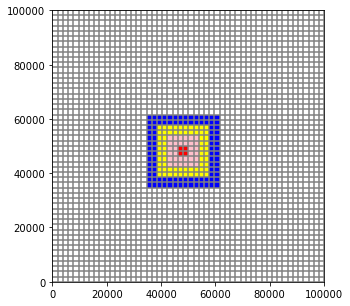

In [12]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
mm = fp.plot.PlotMapView(model=gwffake)#, extent = (30 * delr,70 * delr,30 * delc, 70 * delc))
mm.plot_grid()
fp.plot.plot_shapefile(rf0shp, ax=ax, facecolor='blue', edgecolor='none')
fp.plot.plot_shapefile(rf1shp, ax=ax, facecolor='yellow', edgecolor='none')
fp.plot.plot_shapefile(rf2shp, ax=ax, facecolor='pink', edgecolor='none')
fp.plot.plot_shapefile(rf3shp, ax=ax, facecolor='red', edgecolor='none')

## Now build the grid using the `build()` method on the `Gridgen` object

In [13]:
g.build()

### ... and take a look at the refined grid

(38500.0, 57750.0)

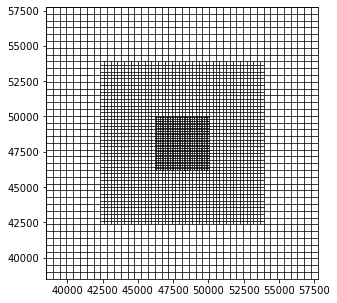

In [14]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
g.plot(ax, linewidth=0.5)
plt.xlim((20*delr,30*delr))
plt.ylim((20*delc,30*delc))

In [15]:
gridprops = g.get_gridprops_disv()
ncpl = gridprops['ncpl']
top = gridprops['top']
botm = gridprops['botm']
nvert = gridprops['nvert']
vertices = gridprops['vertices']
cell2d = gridprops['cell2d']


In [16]:
gridprops

{'nlay': 1,
 'ncpl': 6988,
 'top': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 'botm': array([[-1., -1., -1., ..., -1., -1., -1.]], dtype=float32),
 'nvert': 7241,
 'vertices': [[0, 0.0, 100100.0],
  [1, 1925.0, 100100.0],
  [2, 1925.0, 98175.0],
  [3, 0.0, 98175.0],
  [4, 3850.0, 100100.0],
  [5, 3850.0, 98175.0],
  [6, 5775.0, 100100.0],
  [7, 5775.0, 98175.0],
  [8, 7700.0, 100100.0],
  [9, 7700.0, 98175.0],
  [10, 9625.0, 100100.0],
  [11, 9625.0, 98175.0],
  [12, 11550.0, 100100.0],
  [13, 11550.0, 98175.0],
  [14, 13475.0, 100100.0],
  [15, 13475.0, 98175.0],
  [16, 15400.0, 100100.0],
  [17, 15400.0, 98175.0],
  [18, 17325.0, 100100.0],
  [19, 17325.0, 98175.0],
  [20, 19250.0, 100100.0],
  [21, 19250.0, 98175.0],
  [22, 21175.0, 100100.0],
  [23, 21175.0, 98175.0],
  [24, 23100.0, 100100.0],
  [25, 23100.0, 98175.0],
  [26, 25025.0, 100100.0],
  [27, 25025.0, 98175.0],
  [28, 26950.0, 100100.0],
  [29, 26950.0, 98175.0],
  [30, 28875.0, 100100.0],
  [31, 28875.0, 9817

In [17]:
# initial conditions
ic = fp.mf6.ModflowGwfic(gwf, pname='ic', strt=0.)

In [18]:
gwf

name = theis
model_type = gwf6
version = mf6
model_relative_path = .

###################
Package ic
###################

package_name = ic
filename = theis.ic
package_type = ic
model_or_simulation_package = model
model_name = theis



In [19]:
# disv
disv = fp.mf6.ModflowGwfdisv(gwf, nlay=nlay, ncpl=ncpl, 
                                top=0, botm=botm, 
                                nvert=nvert, vertices=vertices, 
                                cell2d=cell2d)

### `cell2d` is a list of tuples containing node information including number, x,y, and connections

In [20]:
cell2d

[(0, 962.5, 99137.5, 5, 0, 1, 2, 3, 0, None),
 (1, 2887.5, 99137.5, 5, 1, 4, 5, 2, 1, None),
 (2, 4812.5, 99137.5, 5, 4, 6, 7, 5, 4, None),
 (3, 6737.5, 99137.5, 5, 6, 8, 9, 7, 6, None),
 (4, 8662.5, 99137.5, 5, 8, 10, 11, 9, 8, None),
 (5, 10587.5, 99137.5, 5, 10, 12, 13, 11, 10, None),
 (6, 12512.5, 99137.5, 5, 12, 14, 15, 13, 12, None),
 (7, 14437.5, 99137.5, 5, 14, 16, 17, 15, 14, None),
 (8, 16362.5, 99137.5, 5, 16, 18, 19, 17, 16, None),
 (9, 18287.5, 99137.5, 5, 18, 20, 21, 19, 18, None),
 (10, 20212.5, 99137.5, 5, 20, 22, 23, 21, 20, None),
 (11, 22137.5, 99137.5, 5, 22, 24, 25, 23, 22, None),
 (12, 24062.5, 99137.5, 5, 24, 26, 27, 25, 24, None),
 (13, 25987.5, 99137.5, 5, 26, 28, 29, 27, 26, None),
 (14, 27912.5, 99137.5, 5, 28, 30, 31, 29, 28, None),
 (15, 29837.5, 99137.5, 5, 30, 32, 33, 31, 30, None),
 (16, 31762.5, 99137.5, 5, 32, 34, 35, 33, 32, None),
 (17, 33687.5, 99137.5, 5, 34, 36, 37, 35, 34, None),
 (18, 35612.5, 99137.5, 5, 36, 38, 39, 37, 36, None),
 (19, 37537.5

## We can use a little trickery to find all the edge cells at which we will apply a constant head value, pulling values from `cell2d` at the x and y coordinates of the edges of the domain

In [21]:
chd_spd = [i for i in cell2d if i[1] == delr/2] + \
[i for i in cell2d if i[2] == delr/2] + \
[i for i in cell2d if i[1] == ((nrow * delr-1)+delr/2)] + \
[i for i in cell2d if i[2] == ((nrow * delr-1)+delr/2)] 


In [22]:
print(len(chd_spd))
chd_spd = list(set(chd_spd))
chd_spd = [[[0,i[0]],0] for i in chd_spd]
print(len(chd_spd))


104
103


In [23]:
chd_spd

[[[0, 6955], 0],
 [[0, 6969], 0],
 [[0, 1656], 0],
 [[0, 6952], 0],
 [[0, 1228], 0],
 [[0, 6975], 0],
 [[0, 0], 0],
 [[0, 728], 0],
 [[0, 6951], 0],
 [[0, 6954], 0],
 [[0, 6312], 0],
 [[0, 6970], 0],
 [[0, 6965], 0],
 [[0, 6364], 0],
 [[0, 1134], 0],
 [[0, 6961], 0],
 [[0, 6958], 0],
 [[0, 6986], 0],
 [[0, 780], 0],
 [[0, 6980], 0],
 [[0, 6947], 0],
 [[0, 2158], 0],
 [[0, 6949], 0],
 [[0, 6974], 0],
 [[0, 6960], 0],
 [[0, 6832], 0],
 [[0, 6937], 0],
 [[0, 6416], 0],
 [[0, 520], 0],
 [[0, 6967], 0],
 [[0, 6624], 0],
 [[0, 6971], 0],
 [[0, 6941], 0],
 [[0, 4934], 0],
 [[0, 6964], 0],
 [[0, 6976], 0],
 [[0, 6948], 0],
 [[0, 6946], 0],
 [[0, 6957], 0],
 [[0, 676], 0],
 [[0, 832], 0],
 [[0, 6959], 0],
 [[0, 572], 0],
 [[0, 6728], 0],
 [[0, 6940], 0],
 [[0, 6052], 0],
 [[0, 6260], 0],
 [[0, 884], 0],
 [[0, 6208], 0],
 [[0, 6983], 0],
 [[0, 6981], 0],
 [[0, 6944], 0],
 [[0, 52], 0],
 [[0, 6572], 0],
 [[0, 3546], 0],
 [[0, 5650], 0],
 [[0, 5436], 0],
 [[0, 312], 0],
 [[0, 6985], 0],
 [[0, 6968

### We need a few more packages defined to run this

In [24]:
chd = fp.mf6.ModflowGwfchd(gwf, save_flows=True,stress_period_data = chd_spd)

In [25]:
# npf 
hk=0.3

# node property flow
npf = fp.mf6.ModflowGwfnpf(gwf, save_specific_discharge=True,
                              icelltype=[0], 
                              k=[hk],
                              k33=[hk])

In [26]:
# storage
ss=0.0008
stor = fp.mf6.ModflowGwfsto(gwf, ss=ss, transient=True)

### now find the center cell in which to place the pumping well

In [27]:
x = [i[1] for i in cell2d]
y = [i[2] for i in cell2d]
center_cell = gwf.modelgrid.intersect(np.median(x),np.median(y))

In [28]:
center_cell

3270

### Make the well and output control files

In [29]:
# single well in the center
well_sp = [[(0, center_cell), -1.16]]
wel = fp.mf6.ModflowGwfwel(gwf,save_flows=True,stress_period_data=well_sp)

In [30]:
# output control
oc = fp.mf6.ModflowGwfoc(gwf, pname='oc', budget_filerecord='{}.cbc'.format(model_name),
                            head_filerecord='{}.hds'.format(model_name),
                            headprintrecord=[('COLUMNS', 10, 'WIDTH', 15,
                                              'DIGITS', 6, 'GENERAL')],
                            saverecord=[('HEAD', 'ALL'), ('BUDGET', 'ALL')],
                            printrecord=[('HEAD', 'ALL'), ('BUDGET', 'ALL')])

### Make an observation of drawdown at a place to compare with the analytical solution

In [31]:
# find a point 120 meters east of the pumping well
obs_cell = gwf.modelgrid.intersect(np.median(x) + 120, np.median(y))


cobs = fp.mf6.ModflowUtlobs(gwf, digits=25,
                            continuous={'30m_dd_hd_obs.csv':[['obs1dd','drawdown',(0,obs_cell)],
                                                ['obs1hd','head',(0,obs_cell)]]}, pname='head_near_well',
                            filename='30m_dd_hd.obs')

## Now write the files and run

In [32]:
sim.write_simulation()
sim.run_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims...
  writing model theis...
    writing model name file...
    writing package ic...
    writing package disv...
    writing package chd_0...
INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 103 based on size of stress_period_data
    writing package npf...
    writing package sto...
    writing package wel_0...
INFORMATION: maxbound in ('gwf6', 'wel', 'dimensions') changed to 1 based on size of stress_period_data
    writing package oc...
    writing package head_near_well...
FloPy is using the following  executable to run the model: /Users/mnfienen/Documents/bin/MAC_VERSIONS_USGS/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.2.0 10/22/2020

   MODFLOW 6 compiled Oct 25 2020 16:15:39 with IFORT compiler (ver. 19.0.5)

This software has been approve

(True, [])

## read in the head values and plot them

In [33]:
fname = os.path.join(model_dir, model_name + '.hds')
hdobj = fp.utils.HeadFile(fname)
head = hdobj.get_alldata()

In [34]:
head.shape

(75, 1, 1, 6988)

## Plot up the results

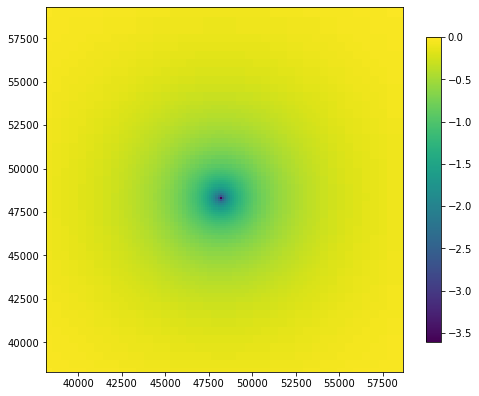

In [35]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
mm = fp.plot.PlotMapView(gwf, ax=ax)
xmid,ymid = cell2d[center_cell][1],cell2d[center_cell][2]
v=mm.plot_array(head[74,0,0:])
plt.xlim((xmid-10050,xmid+10500))
plt.ylim((ymid-10000,ymid+11000))
plt.colorbar(v, shrink=.7)


In [36]:
# turn on XT3D in npf package to compare results
gwf.npf.xt3doptions=True

In [37]:
gwf.npf

package_name = npf
filename = theis.npf
package_type = npf
model_or_simulation_package = model
model_name = theis

Block options
--------------------
xt3doptions
{internal}
([True])

save_specific_discharge
{internal}
(True)


Block griddata
--------------------
icelltype
{constant 0}

k
{constant 0.3}

k33
{constant 0.3}



### Write and run now with XT3D enabled

In [38]:
sim.write_simulation()
sim.run_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims...
  writing model theis...
    writing model name file...
    writing package ic...
    writing package disv...
    writing package chd_0...
    writing package npf...
    writing package sto...
    writing package wel_0...
    writing package oc...
    writing package head_near_well...
FloPy is using the following  executable to run the model: /Users/mnfienen/Documents/bin/MAC_VERSIONS_USGS/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.2.0 10/22/2020

   MODFLOW 6 compiled Oct 25 2020 16:15:39 with IFORT compiler (ver. 19.0.5)

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and 

(True, [])

### Read in the heads again with XT3D and look at the difference on the final timestep

In [39]:
fname = os.path.join(model_dir, model_name + '.hds')
hdobj2 = fp.utils.HeadFile(fname)
head2 = hdobj2.get_alldata()

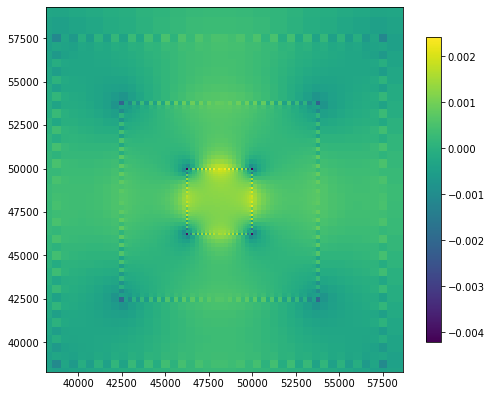

In [40]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
mm = fp.plot.PlotMapView(gwf, ax=ax)
xmid,ymid = cell2d[center_cell][1],cell2d[center_cell][2]
v=mm.plot_array(head[74,0,0:]-head2[74,0,0:])
plt.xlim((xmid-10050,xmid+10500))
plt.ylim((ymid-10000,ymid+11000))
plt.colorbar(v, shrink=.7)

## Now we can compare with our analytical solution
### First let's get the times from the head file to be sure we align times correctly

In [41]:
alltimes = hdobj.get_times()

### Then import and run the Theis script

In [42]:
import theis_script2

In [43]:
dd_analytical = theis_script2.theis_analytical(alltimes)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
1.3215506136570812
the end


In [44]:
if os.path.exists('tmp_images'):
    shutil.rmtree('tmp_images')
os.mkdir('tmp_images')
# make a temporary directory for the images.

## Plot a PDF with one time step per page

In [45]:
with PdfPages('theis_modflow_unstructured_rect_analytical.pdf') as pdfout:
    for i in range(len(alltimes)):
        fig = plt.figure(figsize=(8,8))
        ax = fig.add_subplot(121)
        mm = fp.plot.PlotMapView(gwf, ax=ax)
        ax.set_aspect('equal')
        xmid,ymid = cell2d[center_cell][1],cell2d[center_cell][2]
        v=mm.plot_array(-head[i,0,:],vmin=0,vmax=1.7, cmap='magma')
        ax.set_xlim((xmid-1050,xmid+1050))
        ax.set_ylim((ymid-1050,ymid+1050))

        plt.title('MODFLOW6 Unstructured')
        fig.add_subplot(122)
        plt.imshow(dd_analytical[i], interpolation='nearest',
                  vmin=0,
                  vmax=1.7, cmap='magma')
        plt.title('Analytical')
        plt.suptitle('Theis two ways: timestep = {0}'.format(i+1))
        plt.tight_layout()
        
        pdfout.savefig()
        
        plt.savefig('tmp_images/{0}.png'.format(i))
        plt.close()

## Or we can make a movie using `ffmpeg`

In [46]:
# make a .mpeg
import imageio
import imageio_ffmpeg

mp4_path = 'modflow_theis_unstruc_rect.mp4'
frames_path = 'tmp_images/{i}.png'

with imageio.get_writer(mp4_path, mode='I') as writer:
    for i in range(len(alltimes)):
        writer.append_data(imageio.imread(frames_path.format(i=i)))

### We can also evaluate the errors with and without `xt3d` over simulation time

In [47]:
with PdfPages('errors_rectangular.pdf') as pdfout:
    for i in range(len(alltimes)):
        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(1, 1, 1, aspect='equal')
        mm = fp.plot.PlotMapView(gwf, ax=ax)
        xmid,ymid = cell2d[center_cell][1],cell2d[center_cell][2]
        v=mm.plot_array(head[i,0,0:]-head2[i,0,0:])
        plt.xlim((xmid-10050,xmid+10500))
        plt.ylim((ymid-10000,ymid+11000))
        plt.colorbar(v, shrink=0.6)
        plt.tight_layout()
        plt.title('errors')
        pdfout.savefig()
        plt.close('all')